In [1]:
import pandas as pd
import requests
import json # Importa el módulo 'json'

In [ ]:
def obtener_datos(series_id, site_code):
    """
    Realiza una petición a la API y devuelve un DataFrame.
    """
    url = f"https://alerta.ina.gob.ar/pub/datos/datos&timeStart=2020-10-5&timeEnd=2025-10-5&seriesId={series_id}&siteCode={site_code}&varId=2&format=csv"
    
    try:
        # Lee el CSV directamente desde la URL.
        df = pd.read_csv(url, comment='#', sep=',', header=None)
        df.columns = ['obs_id', 'timestart', 'timeend', 'valor', 'timeupdate']
        
        # Agrega las columnas adicionales
        df['seriesId'] = series_id
        df['siteCode'] = site_code
        
        return df
    
    except Exception as e:
        print(f"Error al obtener datos para seriesId {series_id}: {e}")
        return pd.DataFrame() # Devuelve un DataFrame vacío en caso de error

# Leer el archivo JSON de forma síncrona con Python
try:
    with open("alturasHidrometricas.json", 'r', encoding='utf-8') as file:
        alturas_json = json.load(file)
except FileNotFoundError:
    print("Error: El archivo 'alturasHidrometricas.json' no se encontró.")
    alturas_json = []

lista_de_dataframes = []

for item in alturas_json:
    df_temporal = obtener_datos(item['seriesid'], item['sitecode'])
    lista_de_dataframes.append(df_temporal)

# Concatena todos los DataFrames en uno solo
df_final = pd.concat(lista_de_dataframes, ignore_index=True)

# Muestra las primeras 5 filas del DataFrame final
print(df_final.head())

# Opcional: Guarda el DataFrame final en un solo archivo CSV
df_final.to_csv("datos_finales.csv", index=False)

Error al obtener datos para seriesId 3280: 'utf-8' codec can't decode byte 0xf3 in position 343: invalid continuation byte
Error al obtener datos para seriesId 3309: 'utf-8' codec can't decode byte 0xe1 in position 694: invalid continuation byte
Error al obtener datos para seriesId 3312: 'utf-8' codec can't decode byte 0xe1 in position 316: invalid continuation byte
Error al obtener datos para seriesId 3314: 'utf-8' codec can't decode byte 0xe1 in position 499: invalid continuation byte
Error al obtener datos para seriesId 3345: 'utf-8' codec can't decode byte 0xf3 in position 607: invalid continuation byte
Error al obtener datos para seriesId 3347: 'utf-8' codec can't decode byte 0xf3 in position 634: invalid continuation byte
Error al obtener datos para seriesId 6060: 'utf-8' codec can't decode byte 0xe1 in position 623: invalid continuation byte
Error al obtener datos para seriesId 6061: 'utf-8' codec can't decode byte 0xe1 in position 705: invalid continuation byte
Error al obtener

In [2]:
df_nuevito = pd.read_csv("datos_finales.csv")
df_nuevito.head()

,timeend,seriesId,siteCode,valor
0,2020-10-05,8,8,0.30
1,2020-10-06,8,8,0.67
2,2020-10-07,8,8,1.20
3,2020-10-08,8,8,1.08
4,2020-10-09,8,8,0.96


In [6]:
df = df_nuevito

In [7]:
#Se puede hacer : df.iloc[1 + 10]
df
df['timeend'] = pd.to_datetime(df['timeend'])
df['timeend'] = df['timeend'].dt.date
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358126 entries, 0 to 358125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   timeend   358126 non-null  object 
 1   seriesId  358126 non-null  int64  
 2   siteCode  358126 non-null  int64  
 3   valor     358126 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 10.9+ MB


# Limpiando los datos de los rios para estandarizar su altura segun el promedio de los registros

In [8]:
df_limpio = df.groupby(["timeend", "seriesId", "siteCode"])["valor"].mean().reset_index()

df_limpio['valor'] = df_limpio['valor'].round(2)
df_limpio

,timeend,seriesId,siteCode,valor
0,2020-10-05,8,8,0.30
1,2020-10-05,9,9,9.89
2,2020-10-05,10,10,10.30
3,2020-10-05,11,11,7.70
4,2020-10-05,12,12,7.40
...,...,...,...,...
358121,2025-10-05,37580,7387,1.44
358122,2025-10-05,37581,7388,0.16
358123,2025-10-05,37594,7392,1.44
358124,2025-10-05,37595,6624,0.62


In [9]:
df_limpio = df_limpio.sort_values(by=['seriesId', 'timeend'])


In [10]:
df_limpio.to_csv('altura_rios_limpio.csv')


In [11]:
df_limpio.head()
df_limpio.to_csv("altura_rios_limpio.csv", index=False)

# Una vez generado el df 

In [12]:
df = pd.read_csv('altura_rios_limpio.csv')
df.to_csv('altura_rios_limpio.csv')
df['seriesId'] = df['seriesId'].astype(str)
df['siteCode'] = df['siteCode'].astype(str)
df['rio_id'] = df['seriesId']+"-"+df['siteCode']
df = df.drop('seriesId', axis=1)
df = df.drop('siteCode', axis=1)
df


,timeend,valor,rio_id
0,2020-10-05,0.30,8-8
1,2020-10-06,0.67,8-8
2,2020-10-07,1.20,8-8
3,2020-10-08,1.08,8-8
4,2020-10-09,0.96,8-8
...,...,...,...
358121,2025-10-01,1.11,37597-6622
358122,2025-10-02,1.12,37597-6622
358123,2025-10-03,1.11,37597-6622
358124,2025-10-04,1.11,37597-6622


In [13]:
# Uniendo lat y long con el json de leo
df_cord = pd.read_json('alturasHidrometricas.json')
df_cord = df_cord.drop(columns=['estacion_nombre', 'estacion_tabla','red_nombre','varid', 'var_nombre', 'procid', 'proc_nombre','unitid', 'unit_nombre', 'from_date', 'to_date', 'obs_count'])
df_cord['seriesid'] = df_cord['seriesid'].astype(str)
df_cord['sitecode'] = df_cord['sitecode'].astype(str)
df_cord['rio_id'] = df_cord['seriesid']+"-"+df_cord['sitecode']
df_cord.drop(columns=['seriesid', 'sitecode'])

,lat,lon,rio_id
0,-25.583333,-53.983333,8-8
1,-25.583333,-54.566667,9-9
2,-25.916679,-54.621134,10-10
3,-26.383333,-54.700000,11-11
4,-26.800000,-55.033333,12-12
...,...,...,...
415,-43.349722,-70.879722,37577-7385
416,-32.421944,-63.244722,37578-7386
417,-41.950556,-71.375278,37580-7387
418,-33.307222,-68.061389,37581-7388


In [14]:
df_cord_final = pd.merge(
    df,
    df_cord[['lat', 'lon', 'rio_id']],
    on= ['rio_id'],
    how= 'left'
)
df_cord_final.to_csv("rios_con_cords.csv")
df_cord_final.head()

,timeend,valor,rio_id,lat,lon
0,2020-10-05,0.30,8-8,-25.583333,-53.983333
1,2020-10-06,0.67,8-8,-25.583333,-53.983333
2,2020-10-07,1.20,8-8,-25.583333,-53.983333
3,2020-10-08,1.08,8-8,-25.583333,-53.983333
4,2020-10-09,0.96,8-8,-25.583333,-53.983333


In [ ]:
import pandas as pd
import requests
import json
from urllib.parse import urlencode

# --- CONFIGURACIÓN DE PARÁMETROS FIJOS ---
BASE_URL = "https://archive-api.open-meteo.com/v1/archive"
START_DATE = "2020-10-05"
END_DATE = "2025-10-05"
INPUT_CSV = 'rios_con_cords.csv'
OUTPUT_CSV = 'precipitaciones_diarias_openmeteo.csv'

# Lista para almacenar los DataFrames procesados de cada solicitud
todos_los_datos_precipitacion = []

# ====================================================================
# FUNCIÓN PRINCIPAL: SOLICITUD Y PROCESAMIENTO
# ====================================================================

def obtener_y_sumar_precipitacion(lat, lon):
    """
    Realiza la solicitud a Open-Meteo, suma la precipitación horaria a diaria
    y devuelve un DataFrame limpio con los metadatos.
    """
    # 1. Construcción de Parámetros y URL para la API de Open-Meteo
    params = {
        'latitude': lat,
        'longitude': lon,
        'start_date': START_DATE,
        'end_date': END_DATE,
        'hourly': 'precipitation',
        'timezone': 'America/Sao_Paulo' # Zona horaria para Argentina
    }
    full_url = f"{BASE_URL}?{urlencode(params)}"
    
    try:
        # 2. Solicitud GET a la API
        response = requests.get(full_url, timeout=30)
        response.raise_for_status() # Lanza un error para códigos de estado 4xx/5xx
        data_json = response.json()

        # 3. Limpieza y Creación del DataFrame
        # El JSON tiene dos listas: 'time' y 'precipitation'. Las convertimos a DF
        df = pd.DataFrame({
            'time': data_json['hourly']['time'],
            'precipitation': data_json['hourly']['precipitation']
        })
        
        # 4. Transformación de Datos
        # Convertir la columna 'time' a datetime
        df['time'] = pd.to_datetime(df['time'])
        
        # Extraer la fecha (el día) para la agrupación
        df['date'] = df['time'].dt.date 

        # 5. Agrupación y Suma (El paso clave)
        # Sumamos la precipitación horaria para obtener el total diario
        df_diario = df.groupby('date')['precipitation'].sum().reset_index()
        
        # Renombrar la columna de valor y asegurar el tipo de dato
        df_diario.rename(columns={'precipitation': 'precipitations_value'}, inplace=True)
        df_diario['precipitations_value'] = df_diario['precipitations_value'].round(2)
        
        # 6. Agregar Metadatos de Coordenadas
        df_diario['lat'] = lat
        df_diario['lon'] = lon
        
        print(f"✅ Éxito: Datos obtenidos para LAT: {lat}, LON: {lon} (Días: {len(df_diario)})")
        return df_diario

    except requests.exceptions.RequestException as e:
        print(f"❌ Error en la Solicitud para {lat}, {lon}: {e}")
    except Exception as e:
        print(f"❌ Error inesperado al procesar {lat}, {lon}: {e}")
    
    return pd.DataFrame(columns=['date', 'precipitations_value', 'lat', 'lon']) # Devolvemos un DF vacío en caso de fallo

# ====================================================================
# EJECUCIÓN DEL PROCESO ETL
# ====================================================================
try:
    # 1. Leer el archivo de coordenadas
    df_rios = pd.read_csv(INPUT_CSV)
    
    # 2. Identificar las coordenadas únicas para evitar peticiones duplicadas
    coordenadas_unicas = df_rios[['lat', 'lon']].drop_duplicates().to_records(index=False)
    
    print(f"Iniciando solicitud para {len(coordenadas_unicas)} pares de coordenadas únicos.")

    # 3. Iterar sobre las coordenadas y solicitar datos
    for lat, lon in coordenadas_unicas:
        df_precip = obtener_y_sumar_precipitacion(lat, lon)
        
        if not df_precip.empty:
            todos_los_datos_precipitacion.append(df_precip)

    # 4. Unificación y Carga Final
    if todos_los_datos_precipitacion:
        df_final = pd.concat(todos_los_datos_precipitacion, ignore_index=True)
        
        # Asegurar el orden final de las columnas
        df_final = df_final[['date', 'precipitations_value', 'lat', 'lon']]
        
        # Guardar en el archivo CSV
        df_final.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')
        
        print(f"\n✨ Proceso Completado. Se guardó el archivo '{OUTPUT_CSV}' con un total de {len(df_final)} registros.")
    else:
        print("\n⚠️ No se obtuvieron datos de precipitación de ninguna coordenada.")

except FileNotFoundError:
    print(f"FATAL ERROR: El archivo de entrada '{INPUT_CSV}' no fue encontrado.")
except Exception as e:
    print(f"FATAL ERROR GENERAL: {e}")

Iniciando solicitud para 395 pares de coordenadas únicos.
✅ Éxito: Datos obtenidos para LAT: -25.5833333333333, LON: -53.9833333333333 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -25.5833333333333, LON: -54.5666666666667 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -25.916679, LON: -54.621134 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -26.3833333333333, LON: -54.7 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -26.8, LON: -55.0333333333333 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -27.33509, LON: -55.588412 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -27.3666666666667, LON: -55.8833333333333 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -27.5833333333333, LON: -56.7 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -27.42336098, LON: -57.33326783 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -27.26677773, LON: -58.24407387 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -27.3333333333333, LON: -58.5833333333333 (Días: 1827)
✅ Éxito: Datos obtenidos para LAT: -2

In [15]:
df_precipitaciones = pd.read_csv("precipitaciones_diarias_openmeteo.csv")
df_precipitaciones.head()

,date,precipitations_value,lat,lon
0,2020-10-05,0.0,-25.583333,-53.983333
1,2020-10-06,0.0,-25.583333,-53.983333
2,2020-10-07,0.0,-25.583333,-53.983333
3,2020-10-08,3.0,-25.583333,-53.983333
4,2020-10-09,8.1,-25.583333,-53.983333


# Luego de hacer el proceso de unir las tablas en colab...

In [16]:
#Tenemos este archivo:
df = pd.read_csv("df_rios_alturas_precipitaciones.csv")

In [17]:
df = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])

In [18]:
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358126 entries, 0 to 358125
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   fecha_coincidencia    358126 non-null  object 
 1   valor                 358126 non-null  float64
 2   rio_id                358126 non-null  object 
 3   lat                   358126 non-null  float64
 4   lon                   358126 non-null  float64
 5   precipitations_value  348749 non-null  float64
dtypes: float64(4), object(2)
memory usage: 16.4+ MB
None


,fecha_coincidencia,valor,rio_id,lat,lon,precipitations_value
0,2020-10-05,0.30,8-8,-25.583333,-53.983333,0.0
1,2020-10-06,0.67,8-8,-25.583333,-53.983333,0.0
2,2020-10-07,1.20,8-8,-25.583333,-53.983333,0.0
3,2020-10-08,1.08,8-8,-25.583333,-53.983333,3.0
4,2020-10-09,0.96,8-8,-25.583333,-53.983333,8.1
...,...,...,...,...,...,...
358121,2025-10-01,1.11,37597-6622,-34.216389,-64.386111,NaN
358122,2025-10-02,1.12,37597-6622,-34.216389,-64.386111,NaN
358123,2025-10-03,1.11,37597-6622,-34.216389,-64.386111,NaN
358124,2025-10-04,1.11,37597-6622,-34.216389,-64.386111,NaN


In [19]:
df = df.rename(columns= {'fecha_coincidencia': "date", 'valor': "altura_value", 'precipitations_value': "precipitaciones_value"})
df.head()

,date,altura_value,rio_id,lat,lon,precipitaciones_value
0,2020-10-05,0.30,8-8,-25.583333,-53.983333,0.0
1,2020-10-06,0.67,8-8,-25.583333,-53.983333,0.0
2,2020-10-07,1.20,8-8,-25.583333,-53.983333,0.0
3,2020-10-08,1.08,8-8,-25.583333,-53.983333,3.0
4,2020-10-09,0.96,8-8,-25.583333,-53.983333,8.1


In [20]:
df = df[['date', 'rio_id', 'lat', 'lon', 'altura_value', 'precipitaciones_value']]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358126 entries, 0 to 358125
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   358126 non-null  object 
 1   rio_id                 358126 non-null  object 
 2   lat                    358126 non-null  float64
 3   lon                    358126 non-null  float64
 4   altura_value           358126 non-null  float64
 5   precipitaciones_value  348749 non-null  float64
dtypes: float64(4), object(2)
memory usage: 16.4+ MB


In [22]:
print(f"Cantidad de rios registrados: {len(df['rio_id'].unique())}")
print(f"Cantidad de fechas registradas para cada rio: {len(df['date'].unique())}")

Cantidad de rios registrados: 402
Cantidad de fechas registradas para cada rio: 1827


## Manejo de valores NaN

In [23]:
df["es_null"] = df['precipitaciones_value'].isnull()

In [24]:
df.to_csv("df_rios_precipitaciones_limpio.csv")
df

,date,rio_id,lat,lon,altura_value,precipitaciones_value,es_null
0,2020-10-05,8-8,-25.583333,-53.983333,0.30,0.0,False
1,2020-10-06,8-8,-25.583333,-53.983333,0.67,0.0,False
2,2020-10-07,8-8,-25.583333,-53.983333,1.20,0.0,False
3,2020-10-08,8-8,-25.583333,-53.983333,1.08,3.0,False
4,2020-10-09,8-8,-25.583333,-53.983333,0.96,8.1,False
...,...,...,...,...,...,...,...
358121,2025-10-01,37597-6622,-34.216389,-64.386111,1.11,NaN,True
358122,2025-10-02,37597-6622,-34.216389,-64.386111,1.12,NaN,True
358123,2025-10-03,37597-6622,-34.216389,-64.386111,1.11,NaN,True
358124,2025-10-04,37597-6622,-34.216389,-64.386111,1.11,NaN,True


In [25]:
df["es_null"].value_counts()

es_null
False    348749
True       9377
Name: count, dtype: int64

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Asegurar que las columnas clave estén listas (¡Crucial!)
df['date'] = pd.to_datetime(df['date'])
# Crear la columna booleana (si no existe)
df['es_null'] = df['precipitaciones_value'].isnull() 


# 2. Filtrar el DataFrame para incluir SOLO las filas donde la precipitación es nula
df_nulos = df[df['es_null'] == True].copy()


# 3. Generar el gráfico de dispersión (Scatter Plot)
plt.figure(figsize=(14, 8))

# Graficamos el punto (date) vs. (rio_id) SOLAMENTE para los registros nulos
plt.scatter(
    df_nulos['date'],
    df_nulos['rio_id'],
    s=1,  # Tamaño pequeño del punto (1) para manejar la densidad de datos
    color='red',
    alpha=0.8 # Transparencia ligera
)

# 4. Configurar el Eje X (Fechas)
# Configuramos marcas específicas en los meses finales para un zoom en 2025
fechas_zoom = pd.to_datetime([
    '2024-01-01', '2025-01-01', '2025-07-01', '2025-09-01', '2025-10-05'
])

plt.xticks(
    fechas_zoom,
    [d.strftime('%Y-%m-%d') for d in fechas_zoom],
    rotation=45,
    ha='right'
)


# 5. Etiquetas y Título
plt.title('Distribución de Valores Nulos (NaN) de Precipitación por Río y Fecha', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('ID del Río (Identificador del Grupo de Coordenadas)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6. Encontrar la fecha de corte mínima (para confirmar la hipótesis)
fecha_minima_nulo = df_nulos['date'].min().date()
print(f"\nLa fecha más antigua donde aparece un NaN es: {fecha_minima_nulo}")

KeyboardInterrupt: 

In [27]:
# Muestra cuántas filas (registros de río/fecha) tienes para cada año
df["date"] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
print(df.groupby('year')['date'].count())

year
2020    10803
2021    50735
2022    32307
2023    84587
2024    90088
2025    89606
Name: date, dtype: int64


## Me di cuenta de que casi no hay rios registrados en 2020-2022.
### Solucion: eliminar esos años de raiz y completar la limpieza

In [28]:
fecha_limite = pd.to_datetime('2023-01-01')
pd.to_datetime(df['date'])
#TIRAR ABAJO DESDE 2022
df = df[df['date'] > fecha_limite]
df

,date,rio_id,lat,lon,altura_value,precipitaciones_value,es_null,year
815,2023-01-02,8-8,-25.583333,-53.983333,0.01,46.5,False,2023
816,2023-01-03,8-8,-25.583333,-53.983333,-0.02,20.8,False,2023
817,2023-01-04,8-8,-25.583333,-53.983333,0.64,5.5,False,2023
818,2023-01-05,8-8,-25.583333,-53.983333,0.56,0.0,False,2023
819,2023-01-06,8-8,-25.583333,-53.983333,0.42,0.0,False,2023
...,...,...,...,...,...,...,...,...
358121,2025-10-01,37597-6622,-34.216389,-64.386111,1.11,NaN,True,2025
358122,2025-10-02,37597-6622,-34.216389,-64.386111,1.12,NaN,True,2025
358123,2025-10-03,37597-6622,-34.216389,-64.386111,1.11,NaN,True,2025
358124,2025-10-04,37597-6622,-34.216389,-64.386111,1.11,NaN,True,2025


In [29]:
#stats del dataframe final antes de limpiar:
print(df['es_null'].value_counts())
print(len(df['date'].unique()))

es_null
False    257140
True       6982
Name: count, dtype: int64
1008


### Estas estadisticas (Hay 7 datos faltantes por rio aprox) Querria decir que los unicos datos faltantes son los ultimos 7 de todos los dias. Vamos a comprobarlo...

In [30]:
print(df['es_null'].value_counts())
fecha_limite = pd.to_datetime('2025-09-28')
pd.to_datetime(df['date'])
#TIRAR ABAJO DESDE 2022
test = df[df['date'] < fecha_limite]
print(test['es_null'].value_counts())

es_null
False    257140
True       6982
Name: count, dtype: int64
es_null
False    254682
True       6885
Name: count, dtype: int64


### Esto muestra que no. Solo eliminamos 100 resultados no nulos. Cuando hay 6mil

In [31]:
df.reset_index(drop=True, inplace=True) 
df

,date,rio_id,lat,lon,altura_value,precipitaciones_value,es_null,year
0,2023-01-02,8-8,-25.583333,-53.983333,0.01,46.5,False,2023
1,2023-01-03,8-8,-25.583333,-53.983333,-0.02,20.8,False,2023
2,2023-01-04,8-8,-25.583333,-53.983333,0.64,5.5,False,2023
3,2023-01-05,8-8,-25.583333,-53.983333,0.56,0.0,False,2023
4,2023-01-06,8-8,-25.583333,-53.983333,0.42,0.0,False,2023
...,...,...,...,...,...,...,...,...
264117,2025-10-01,37597-6622,-34.216389,-64.386111,1.11,NaN,True,2025
264118,2025-10-02,37597-6622,-34.216389,-64.386111,1.12,NaN,True,2025
264119,2025-10-03,37597-6622,-34.216389,-64.386111,1.11,NaN,True,2025
264120,2025-10-04,37597-6622,-34.216389,-64.386111,1.11,NaN,True,2025


C:\Users\COMPU\AppData\Local\Temp\ipykernel_9836\73593455.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rios_con_nulos.rename(columns={'es_null': 'conteo_nulos'}, inplace=True)


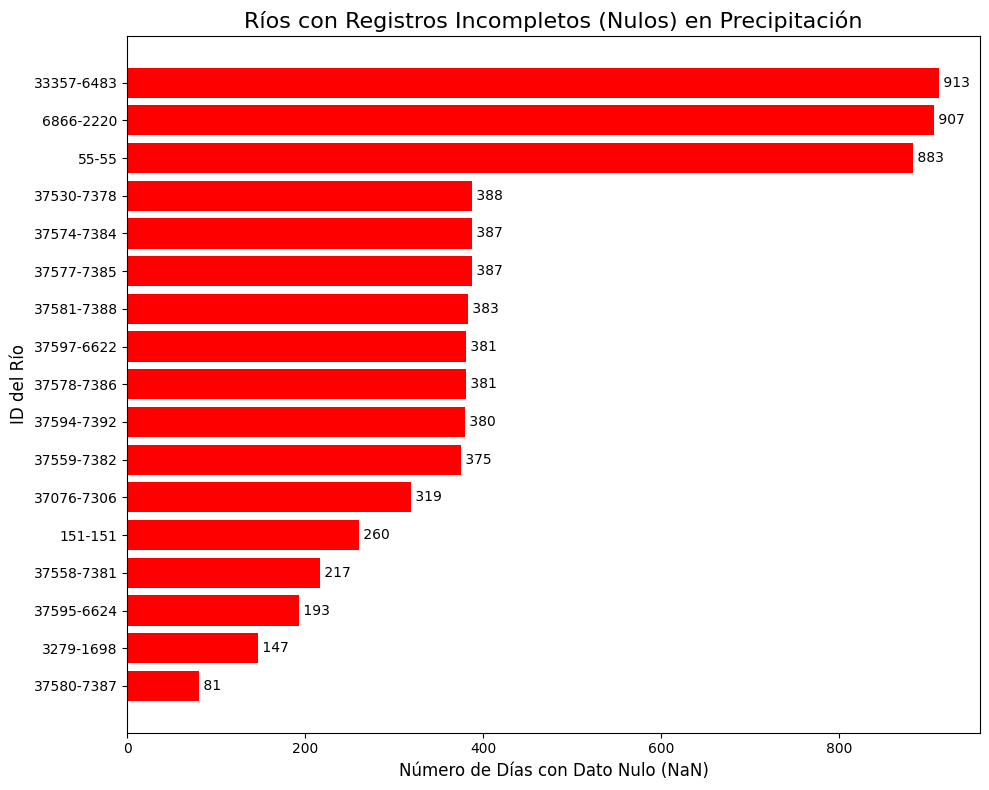

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Agrupar y contar los nulos por cada río
# Al sumar la columna booleana 'es_nulo' (donde True=1, False=0), obtenemos el conteo de nulos.
conteo_nulos_por_rio = df.groupby('rio_id')['es_null'].sum().reset_index()

# 2. Filtrar: Solo nos interesan los ríos que tienen AL MENOS un nulo (Conteo > 0)
rios_con_nulos = conteo_nulos_por_rio[conteo_nulos_por_rio['es_null'] > 0]

# Renombrar la columna de conteo para mayor claridad
rios_con_nulos.rename(columns={'es_null': 'conteo_nulos'}, inplace=True)


# 3. Preparar el Gráfico
# Ordenamos los ríos por la cantidad de nulos (de mayor a menor)
rios_con_nulos = rios_con_nulos.sort_values(by='conteo_nulos', ascending=False)

# Definir el tamaño del gráfico
# Usamos un tamaño grande, ajustando la altura si hay muchos ríos (ej. 10 pulgadas por cada 50 ríos)
altura_figura = max(8, len(rios_con_nulos) * 0.2) 
plt.figure(figsize=(10, altura_figura))

# 4. Generar el Gráfico de Barras Horizontal
plt.barh(
    rios_con_nulos['rio_id'],  # Eje Y: ID del Río
    rios_con_nulos['conteo_nulos'], # Eje X: Cantidad de Nulos
    color='red' 
)

# 5. Etiquetas y Título
plt.title('Ríos con Registros Incompletos (Nulos) en Precipitación', fontsize=16)
plt.xlabel('Número de Días con Dato Nulo (NaN)', fontsize=12)
plt.ylabel('ID del Río', fontsize=12)
plt.gca().invert_yaxis() # Invierte el eje Y para que el río con más nulos esté arriba

# Opcional: Agregar el valor exacto encima de cada barra
for index, value in enumerate(rios_con_nulos['conteo_nulos']):
    plt.text(value, index, f' {int(value)}', va='center')

plt.tight_layout()
plt.show()

In [32]:
import pandas as pd

# 1. Lista de IDs de los ríos a eliminar completamente
ids_a_eliminar = [
    '33357-6483', '6866-2220', '55-55', '37530-7378', '37574-7384', 
    '37577-7385', '37581-7388', '37597-6622', '37578-7386', '37594-7392', 
    '37559-7382', '37076-7306', '151-151', '37558-7381', '37595-6624', 
    '3279-1698', '37580-7387'
]

# Asegúrate de que tu DataFrame esté cargado y se llame 'df'


# --- ELIMINACIÓN DE RÍOS Y ESTADÍSTICAS ---

filas_antes = len(df)

# Filtro: Mantener las filas donde 'rio_id' NO está en la lista de eliminación.
# Esto elimina TODAS las filas asociadas a esos 17 IDs, sin importar la fecha.
df_limpio = df[~df['rio_id'].isin(ids_a_eliminar)].copy()

# Resultados
filas_eliminadas = filas_antes - len(df_limpio)
rios_eliminados = len(ids_a_eliminar) # Ya que eliminamos los 17 IDs

print("\n--- RESUMEN DE LIMPIEZA POR RÍO ---")
print(f"Número de ríos eliminados: {rios_eliminados}")
print(f"❌ Filas eliminadas (incluyendo todos sus registros): {filas_eliminadas}")
print(f"✨ Filas restantes en el DataFrame: {len(df_limpio)}")
print("----------------------------------\n")

# Continúa trabajando con 'df_limpio'


--- RESUMEN DE LIMPIEZA POR RÍO ---
Número de ríos eliminados: 17
❌ Filas eliminadas (incluyendo todos sus registros): 6982
✨ Filas restantes en el DataFrame: 257140
----------------------------------



In [ ]:
print(df_limpio['es_null'].value_counts())
df_limpio = df_limpio.drop(columns=['es_nulo', 'year'])
df_limpio

es_null
False    257140
Name: count, dtype: int64


KeyError: "['es_nulo'] not found in axis"

## Ahora si, el DF esta limpio. (No tiene ningun valor null)

In [34]:
print(f"La cantidad de rios es de {len(df_limpio["rio_id"].unique())}")
print(f"La cantidad registros por rio es de {len(df_limpio["date"].unique())}")

La cantidad de rios es de 379
La cantidad registros por rio es de 1008


## Como faltan filas, ya que se esperaban mas de las que hay...

In [35]:
import pandas as pd

# 1. Asegurar que la columna 'date' sea el índice y de tipo Datetime
df_limpio['date'] = pd.to_datetime(df_limpio['date'])

# 2. Definir el rango de fechas completo y continuo
fecha_minima = df_limpio['date'].min()
fecha_maxima = df_limpio['date'].max()
rango_completo = pd.date_range(start=fecha_minima, end=fecha_maxima, freq='D')

# 3. Función de Detección y Conteo de Huecos
def contar_dias_faltantes(grupo_df):
    """Devuelve el número de días faltantes para un río."""
    
    # Establecer la fecha como índice para este río
    df_temporal = grupo_df.set_index('date')
    
    # Aplicar reindexación: rellena las fechas faltantes con NaN
    df_reindexado = df_temporal.reindex(rango_completo)
    
    # Contar los lugares donde 'altura_value' es nulo
    dias_faltantes = df_reindexado['altura_value'].isnull().sum()
    
    return dias_faltantes


# 4. Aplicar la función a cada río y obtener el conteo
print("Iniciando el conteo de días faltantes...")
conteo_huecos = df_limpio.groupby('rio_id').apply(contar_dias_faltantes)


# 5. Crear y Mostrar la Tabla de Resultados
df_conteo_final = conteo_huecos.reset_index(name='dias_faltantes')

# Filtrar: Mostrar solo los ríos que tienen huecos (> 0 días faltantes)
df_conteo_final = df_conteo_final[df_conteo_final['dias_faltantes'] > 0]

# Ordenar de mayor a menor falta de datos
df_conteo_final = df_conteo_final.sort_values(by='dias_faltantes', ascending=False)

print("\n--- RÍOS CON DÍAS DE REGISTRO FALTANTES ---")
print(f"Total de ríos analizados: {df_limpio['rio_id'].nunique()}")
print(f"Total de ríos con huecos: {len(df_conteo_final)}")
print("\nTabla de Registros Faltantes:")
print(df_conteo_final)


Iniciando el conteo de días faltantes...

--- RÍOS CON DÍAS DE REGISTRO FALTANTES ---
Total de ríos analizados: 379
Total de ríos con huecos: 372

Tabla de Registros Faltantes:
         rio_id  dias_faltantes
354       85-85             999
264       52-52             986
235  36963-7276             961
106  33252-6740             954
230  36918-7265             949
..          ...             ...
296   6785-2122               4
347   8230-2607               2
363   9197-2824               1
295   6778-2165               1
337   7355-2355               1

[372 rows x 2 columns]


C:\Users\COMPU\AppData\Local\Temp\ipykernel_2832\1529786766.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conteo_huecos = df_limpio.groupby('rio_id').apply(contar_dias_faltantes)


In [36]:
# Asumimos que df_conteo_final solo contiene ríos con dias_faltantes > 0
# y está ordenado.
df_conteo_final = df_conteo_final.drop(columns=["index", "level_0"])

KeyError: "['index', 'level_0'] not found in axis"

In [37]:
type(df_conteo_final)
df_conteo_final_de_faltantes = df_conteo_final.to_csv('df_conteo_final_de_faltantes.csv')

In [38]:
df_conteo_final_de_faltantes = pd.read_csv("df_conteo_final_de_faltantes.csv")
df_conteo_final_de_faltantes = df_conteo_final_de_faltantes.drop(columns="Unnamed: 0")

In [39]:
df_conteo_final_de_faltantes = df_conteo_final.to_csv('df_conteo_final_de_faltantes.csv')
df_conteo_final_de_faltantes = pd.read_csv("df_conteo_final_de_faltantes.csv")



In [40]:
# 1. Calcular la cantidad de registros que debería tener un río "perfecto"
# Asumimos que el periodo va desde la fecha mínima a la fecha máxima del DF.
fecha_minima = df_limpio['date'].min()
fecha_maxima = df_limpio['date'].max()
dias_esperados = (fecha_maxima - fecha_minima).days + 1 
# Si el cálculo es complicado, simplemente usa el número que ya conoces (ej. 1008)
# dias_esperados = 1008 

# 2. Contar los registros reales de cada río
conteo_por_rio = df_limpio.groupby('rio_id').size().reset_index(name='registros_reales')

# 3. Filtrar para encontrar los ríos completos
rios_completos = conteo_por_rio[conteo_por_rio['registros_reales'] == dias_esperados]

print(f"La cantidad de registros esperada (días) es: {dias_esperados}")

if not rios_completos.empty:
    print("\n✅ ¡Ríos con el registro completo encontrado!")
    print(rios_completos)
else:
    print("\n❌ No se encontró ningún río que tenga el registro completo (exactamente el número de días esperados).")
    print("El río más completo tiene:")
    print(conteo_por_rio.sort_values(by='registros_reales', ascending=False).head(1))

La cantidad de registros esperada (días) es: 1008

✅ ¡Ríos con el registro completo encontrado!
        rio_id  registros_reales
288  6746-2123              1008
300  6800-2197              1008
303  6807-2158              1008
327  6929-2135              1008
330  6952-2137              1008
362  9192-2732              1008
366  9410-2823              1008


In [41]:
import pandas as pd

df_filtrado = df[df['rio_id'] == "6746-2123"].copy()

lista = df_filtrado.to_dict('records')

df_filtrado.to_csv('registros_rio_6746.csv', index=False)

print("Bucle (filtrado) terminado correctamente!")

Bucle (filtrado) terminado correctamente!


In [42]:
df_filtrado

,date,rio_id,lat,lon,altura_value,precipitaciones_value,es_null,year
80364,2023-01-02,6746-2123,-36.397778,-67.140278,-0.06,0.0,False,2023
80365,2023-01-03,6746-2123,-36.397778,-67.140278,-0.06,0.0,False,2023
80366,2023-01-04,6746-2123,-36.397778,-67.140278,-0.06,0.0,False,2023
80367,2023-01-05,6746-2123,-36.397778,-67.140278,-0.06,0.1,False,2023
80368,2023-01-06,6746-2123,-36.397778,-67.140278,-0.06,0.1,False,2023
...,...,...,...,...,...,...,...,...
81367,2025-10-01,6746-2123,-36.397778,-67.140278,0.75,0.0,False,2025
81368,2025-10-02,6746-2123,-36.397778,-67.140278,0.78,0.0,False,2025
81369,2025-10-03,6746-2123,-36.397778,-67.140278,0.81,0.0,False,2025
81370,2025-10-04,6746-2123,-36.397778,-67.140278,0.83,0.4,False,2025


In [43]:
df_filtrado["date"] = pd.to_datetime(df_filtrado["date"])

df_filtrado = df_filtrado.sort_values(by="date")


df_filtrado['altura_7_dias'] = df_filtrado['altura_value'].shift(periods=-7)


df_filtrado

,date,rio_id,lat,lon,altura_value,precipitaciones_value,es_null,year,altura_7_dias
80364,2023-01-02,6746-2123,-36.397778,-67.140278,-0.06,0.0,False,2023,-0.06
80365,2023-01-03,6746-2123,-36.397778,-67.140278,-0.06,0.0,False,2023,-0.06
80366,2023-01-04,6746-2123,-36.397778,-67.140278,-0.06,0.0,False,2023,-0.06
80367,2023-01-05,6746-2123,-36.397778,-67.140278,-0.06,0.1,False,2023,-0.06
80368,2023-01-06,6746-2123,-36.397778,-67.140278,-0.06,0.1,False,2023,-0.06
...,...,...,...,...,...,...,...,...,...
81367,2025-10-01,6746-2123,-36.397778,-67.140278,0.75,0.0,False,2025,NaN
81368,2025-10-02,6746-2123,-36.397778,-67.140278,0.78,0.0,False,2025,NaN
81369,2025-10-03,6746-2123,-36.397778,-67.140278,0.81,0.0,False,2025,NaN
81370,2025-10-04,6746-2123,-36.397778,-67.140278,0.83,0.4,False,2025,NaN


In [44]:
# 1. Ordenar por fecha (¡Necesario!)
df_filtrado["date"] = pd.to_datetime(df_filtrado["date"])
df_filtrado = df_filtrado.sort_values(by="date")
